In [ ]:
!pip install jaxopt

import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import jax
from jax import grad, vmap
import jax.numpy as jnp
import torch
import tqdm
import scipy
from scipy import integrate
import jaxopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 2.6 MB/s eta 0:00:00


In [ ]:
jax.config.update("jax_enable_x64", True)

In [ ]:
#Exponential kernel for two inputs i.e. ID
def kernel(s,t,params):
  #K = params[1]**2*jnp.exp(-jnp.abs(s-t)**2/(2*params[0]**2))

  #K = jnp.exp(-jnp.abs(s-t)**2/(2*params[0]**2))
  K = (1+jnp.sqrt(5)*jnp.abs(s-t)/params[0]+5/3*jnp.abs(s-t)**2/params[0]**2)*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/params[0])

  return K


In [ ]:
def kernel_u(s,t,params):
  #K = -(s-t)*kernel(s,t,params)/params[0]**2
  K = -5*(s-t)*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/params[0])*(params[0]+jnp.sqrt(5)*jnp.abs(s-t))/(3*params[0]**3)
  return K

def kernel_z(s,t,params):
  #K = (s-t)*kernel(s,t,params)/params[0]**2
  K = 5*(s-t)*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/params[0])*(params[0]+jnp.sqrt(5)*jnp.abs(s-t))/(3*params[0]**3)
  return K

def kernel_uz(s,t,params):
  #K = (params[0]**2-(s-t)**2)*kernel(s,t,params)/params[0]**4
  K = 5*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/params[0])*(jnp.sqrt(5)*params[0]*jnp.abs(s-t)+params[0]**2-5*(s-t)**2)/(3*params[0]**4)
  return K

def kernel_uuz(s,t,params):
  #K = (s-t)*((s-t)**2-3*params[0]**2)*kernel(s,t,params)/params[0]**6
  K = 25*(s-t)*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/params[0])*(jnp.sqrt(5)*jnp.abs(s-t)-3*params[0])/(3*params[0]**5)
  return K

def kernel_uzz(s,t,params):
  #K = -(s-t)*((s-t)**2-3*params[0]**2)*kernel(s,t,params)/params[0]**6
  K = -25*(s-t)*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/params[0])*(jnp.sqrt(5)*jnp.abs(s-t)-3*params[0])/(3*params[0]**5)
  return K

def kernel_uu(s,t,params):
  #K = ((s-t)**2-params[0]**2)*kernel(s,t,params)/params[0]**4
  K =  -5*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/params[0])*(jnp.sqrt(5)*params[0]*jnp.abs(s-t)+params[0]**2-5*(s-t)**2)/(3*params[0]**4)
  return K

def kernel_zz(s,t,params):
  #K = ((s-t)**2-params[0]**2)*kernel(s,t,params)/params[0]**4
  K =  -5*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/params[0])*(jnp.sqrt(5)*params[0]*jnp.abs(s-t)+params[0]**2-5*(s-t)**2)/(3*params[0]**4)
  return K

def kernel_uuzz(s,t,params):
  #K = kernel(s,t,params)*(3*params[0]**4-6*params[0]**2*(s-t)**2+(s-t)**4)/params[0]**8
  K = -25*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/params[0])*(5*jnp.sqrt(5)*params[0]*jnp.abs(s-t)-(3*params[0]**2+5*(s-t)**2))/(3*params[0]**6)
  return K

In [ ]:
#Kernel matrix K
def K_Matrix(X,Y,params,reg=False,nugget=10**-5):

  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  val = vmap(lambda s, t: kernel(s,t,params))(X0.flatten(),np.transpose(Y0).flatten())

  K_matrix=np.reshape(val,(size,size2))
  if reg==True and size==size2:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

In [ ]:
#Start and end times for space (x) and time (t)
xbegin=0
xfinal=1
Tstart=0
Tend=1

#Space step
h=1/800

x = np.arange(xbegin, xfinal+h, h)

m=len(x)-1
nu= 0.5


In [ ]:
#Parameters for Burgers
b = 1
a = 0.6
k = 2*np.pi
b2 = 7
a2 = 3.2

In [ ]:
k = 2*np.pi
burger_test=np.zeros((m+1,1))
burger_train1=np.zeros((m+1,1))

burger_test[:,0] = (2*nu*a2*k*np.sin(k*x))/(b2+a2*np.cos(k*x))
burger_test[:,0] = 100+3*x
burger_train1[:,0] = burger_test[:,0]
#burger_train1[:,0] =  (2*nu*a*k*np.sin(k*x))/(b+a*np.cos(k*x))


In [ ]:
#Compute primitive of Burger's equation

antiburger_test=np.zeros((m+1,1))
antiburger_train1=np.zeros((m+1,1))

for j in range(m+1):
  antiburger_test[j,0] = integrate.simpson(burger_test[:j+1,0],x[:j+1])
  antiburger_train1[j,0] = integrate.simpson(burger_train1[:j+1,0],x[:j+1])

Streaming output truncated to the last 5000 lines.
 0.75375 0.755   0.75625 0.7575  0.75875 0.76    0.76125 0.7625  0.76375
 0.765   0.76625 0.7675  0.76875 0.77    0.77125 0.7725  0.77375 0.775
 0.77625 0.7775  0.77875 0.78    0.78125 0.7825  0.78375 0.785   0.78625
 0.7875  0.78875 0.79    0.79125 0.7925  0.79375 0.795   0.79625 0.7975
 0.79875 0.8     0.80125 0.8025  0.80375 0.805   0.80625 0.8075  0.80875
 0.81    0.81125 0.8125  0.81375 0.815   0.81625 0.8175  0.81875 0.82
 0.82125 0.8225  0.82375 0.825   0.82625 0.8275  0.82875 0.83    0.83125
 0.8325  0.83375 0.835   0.83625 0.8375  0.83875 0.84    0.84125 0.8425
 0.84375 0.845   0.84625 0.8475  0.84875 0.85    0.85125 0.8525  0.85375
 0.855   0.85625 0.8575  0.85875 0.86    0.86125 0.8625  0.86375 0.865
 0.86625 0.8675  0.86875 0.87    0.87125 0.8725  0.87375 0.875   0.87625
 0.8775  0.87875 0.88    0.88125 0.8825  0.88375 0.885   0.88625 0.8875
 0.88875 0.89    0.89125 0.8925  0.89375 0.895   0.89625 0.8975  0.89875
 0.9     0

In [ ]:
#First derivative with respect to u
def K_du(X,Y,params,reg=False,nugget=10**-5):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  K_du = vmap(lambda s, t: kernel_u(s,t,params))(X0.flatten(),np.transpose(Y0).flatten())
  K_du = np.reshape(K_du,(size,size2))

  if reg==True and size==size2:
    K_du+=+nugget*jnp.eye(size)
  return K_du

In [ ]:
#First derivative with respect to z
def K_dz(X,Y,params,reg=False,nugget=10**-5):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  K_dz = vmap(lambda s, t: kernel_z(s,t,params))(X0.flatten(),np.transpose(Y0).flatten())
  K_dz = np.reshape(K_dz,(size,size2))

  if reg==True and size==size2:
    K_dz+=+nugget*jnp.eye(size)
  return K_dz

In [ ]:
#Second derivative with respect to z
def K_dzz(X,Y,params,reg=False,nugget=10**-5):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  K_dzz = vmap(lambda s, t: kernel_uu(s,t,params))(X0.flatten(),np.transpose(Y0).flatten())
  K_dzz = np.reshape(K_dzz,(size,size2))

  if reg==True and size==size2:
    K_dzz+=+nugget*jnp.eye(size)
  return K_dzz

In [ ]:
#Second derivative with respect to u
def K_duu(X,Y,params,reg=False,nugget=10**-5):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  K_duu = vmap(lambda s, t: kernel_uu(s,t,params))(X0.flatten(),np.transpose(Y0).flatten())
  K_duu = np.reshape(K_duu,(size,size2))

  if reg==True and size==size2:
    K_duu+=+nugget*jnp.eye(size)
  return K_duu

In [ ]:
#d/du d/uz K(u,z)
def K_duz(X,Y,params,reg=False,nugget=10**-5):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  K_duz = vmap(lambda s, t: kernel_uz(s,t,params))(X0.flatten(),np.transpose(Y0).flatten())
  K_duz = np.reshape(K_duz,(size,size2))

  if reg==True and size==size2:
    K_duz+=+nugget*jnp.eye(size)
  return K_duz

In [ ]:
#d/dz d/du^2 K(u,z)
def K_duuz(X,Y,params,reg=False,nugget=10**-5):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  K_duuz = vmap(lambda s, t: kernel_uuz(s,t,params))(X0.flatten(),np.transpose(Y0).flatten())
  K_duuz = np.reshape(K_duuz,(size,size2))

  if reg==True and size==size2:
    K_duuz+=+nugget*jnp.eye(size)
  return K_duuz

In [ ]:
#d/dz^2 d/du K(u,z)
def K_duzz(X,Y,params,reg=False,nugget=10**-5):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  K_duzz = vmap(lambda s, t: kernel_uzz(s,t,params))(X0.flatten(),np.transpose(Y0).flatten())
  K_duzz = np.reshape(K_duzz,(size,size2))

  if reg==True and size==size2:
    K_duzz+=+nugget*jnp.eye(size)
  return K_duzz

In [ ]:
#d/dz^2 d/du^2 K(u,z)
def K_duuzz(X,Y,params,reg=False,nugget=10**-5):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  K_duuzz = vmap(lambda s, t: kernel_uuzz(s,t,params))(X0.flatten(),np.transpose(Y0).flatten())
  K_duuzz = np.reshape(K_duuzz,(size,size2))

  if reg==True and size==size2:
    K_duuzz+=+nugget*jnp.eye(size)
  return K_duuzz

In [ ]:
#Train data
antiburger_train = antiburger_train1
burger_train = burger_train1

In [ ]:
#Reshape
train = antiburger_train
train_size = antiburger_train.shape[0]

Y = np.eye(1,train_size+2).reshape((train_size+2,1))

In [ ]:
#Returns true heat equation solution
def heat(u):
  return (jnp.exp(-u/(2*nu))-jnp.exp(-1/(2*nu)))/(1-jnp.exp(-1/(2*nu)))

In [ ]:
def matrix_assembly(X,params):

  #Constructs K(\phi,\phi)
  size = len(X[:,0])
  K = jnp.zeros((size+2,size+2))

  K_u = K_du(X,X,params)
  K_uu = K_duu(X,X,params)
  K_uz = K_duz(X,X,params)
  K_uzz = K_duzz(X,X,params)
  K_uuz = K_duuz(X,X,params)
  K_uuzz = K_duuzz(X,X,params)


  K = K.at[1:size+1,1:size+1].set(nu**2*K_uuzz+nu/2*K_uuz+nu/2*K_uzz+1/4*K_uz)
  K = K.at[0,0].set(kernel(0,0,params))
  K = K.at[size+1,size+1].set(kernel(1,1,params))
  K = K.at[0,size+1].set(kernel(0,1,params))
  K = K.at[size+1,0].set(K[0,size+1])

  K = K.at[1:size+1,0].set(jnp.diag(nu*K_duu(X,jnp.zeros((size,1)),params)+1/2*K_du(X,jnp.zeros((size,1)),params)))
  K = K.at[0,1:size+1].set(K[1:size+1,0])
  K = K.at[1:size+1,size+1].set(jnp.diag(nu*K_duu(X,jnp.ones((size,1)),params)+1/2*K_du(X,jnp.ones((size,1)),params)))
  K = K.at[size+1,1:size+1].set(K[1:size+1,size+1])

  return K

In [ ]:
#Computes vector K(u,\phi)
def K_vector(X_test,X_train,params):
  size=len(X_test[:,0])
  size2 = len(X_train[:,0])

  K_vector = jnp.zeros((size,size2+2))

  X_test = X_test[:,0].reshape((size,1))
  X_train = X_train[:,0].reshape((size2,1))

  #K(u,\phi_i) where 2<=i<=N+1

  K_vector = K_vector.at[:,1:size2+1].set(nu*K_dzz(X_test,X_train,params)+1/2*K_dz(X_test,X_train,params))

  #K(u,\phi_1)
  K_vector = K_vector.at[:,0].set(jnp.diag(K_Matrix(X_test,np.zeros((size,1)),params,nugget=False)))

  #K(u,\phi_{N+2})
  K_vector = K_vector.at[:,size2+1].set(jnp.diag(K_Matrix(X_test,np.ones((size,1)),params,nugget=False)))

  return K_vector

In [ ]:
#Kernel regression for one dimension K(u,\phi)K(\phi,\phi)^-1 Y
def kernel_regression(X_test, Y_train,params,K_matrix,X_train,nugget=10**-4):
    t_matrix = K_vector(X_test,X_train,params)
    prediction = jnp.matmul(t_matrix,jnp.linalg.inv(K_matrix+nugget*jnp.eye(len(K_matrix[:,0])))@Y_train)
    return prediction

In [ ]:
def rho(params,lambda1=1*10**-5):
  train_size = len(antiburger_train[:,0])

  train = antiburger_train[:,0].reshape((train_size,1))

  K = matrix_assembly(train,params)

  p_sample = 1
  sample = np.concatenate((np.array([True]),np.random.choice([True,False],size=train_size,p=[p_sample,1-p_sample]),np.array([True])),axis=0)
  sample_indices = np.arange(0,len(sample))[sample]


  p_subsample = 0.5

  #Construct K^\pi (\phi,\phi)

  subsample = np.concatenate((np.array([True]),np.random.choice([True,False],size=len(sample_indices)-2,p=[p_subsample,1-p_subsample]),np.array([True])),axis=0)
  subsample_indices = np.arange(0,len(subsample))[subsample]

  train_sample = train[sample[1:len(sample)-1]]

  train_subsample = train_sample[subsample[1:len(subsample)-1]]

  K_sample = K[:,sample][sample,:]
  Y_sample = Y[:len(K_sample[:,0])][:,0]



  #Construct K^\beta (\phi,\phi)
  K_subsample = K_sample[:,subsample][subsample,:]
  Y_subsample = Y[:len(K_subsample[:,0])][:,0]


  #compute rho= 1 - Y^beta T K^\beta (\phi,\phi) Y^beta/ Y^pi T K^\pi (\phi,\phi) Y^pi

  top = jnp.dot(Y_subsample,jnp.linalg.inv(K_subsample+lambda1*jnp.eye(len(K_subsample[:,0])))@Y_subsample)
  bottom = jnp.dot(Y_sample,jnp.linalg.inv(K_sample+lambda1*jnp.eye(len(K_sample[:,0])))@Y_sample)

  rho = 1-top/bottom

  return rho

In [ ]:
train_size = len(antiburger_train[:,0])
train = antiburger_train[:,0].reshape((train_size,1))

def rho_alternative(params,lambda1=1*10**-13):
  #Construct K^\pi (\phi,\phi)
  K = matrix_assembly(train,params)

  bottom = jnp.dot(Y[:,0],jnp.linalg.inv(K+lambda1*jnp.eye(len(K[:,0])))@Y[:,0])
  top = 0


  for i in range(len(train[:,0])):
    train_sample =  np.delete(np.arange(0,len(train[:,0])+2),i+1)
    #Construct K^\beta (\phi,\phi)
    K_sample = K[:,train_sample][train_sample,:]
    Y_sample = Y[:len(K_sample[:,0])][:,0]
    #compute rho= (N - Y^beta T K^\beta (\phi,\phi) Y^beta/ Y^pi T K^\pi (\phi,\phi) Y^pi)/N
    top += jnp.dot(Y_sample,jnp.linalg.inv(K_sample+lambda1*jnp.eye(len(K_sample[:,0])))@Y_sample)

  rho = (train_size-top/bottom)/train_size

  return rho

In [ ]:
def rho_l2(params,lambda1=1*10**-10):
  #Construct K^\pi (\phi,\phi)
  K = matrix_assembly(train,params)

  full_regressor = kernel_regression(X_test=train,Y_train=Y[:,0],X_train=train,K_matrix= K,params=params,nugget=lambda1)

  bottom = jnp.linalg.norm(full_regressor)**2
  top = 0


  for i in range(len(train[:,0])):
    train_sample =  np.delete(np.arange(0,len(train[:,0])+2),i+1)
    #Construct K^\beta (\phi,\phi)
    K_sample = K[:,train_sample][train_sample,:]
    Y_sample = Y[:len(K_sample[:,0])][:,0]
    sample = np.delete(train[:,0],i).reshape((train_size-1,1))
    #compute rho= (N - Y^beta T K^\beta (\phi,\phi) Y^beta/ Y^pi T K^\pi (\phi,\phi) Y^pi)/N
    sample_regressor = kernel_regression(X_test=train,Y_train=Y_sample,X_train=sample,K_matrix= K_sample,params=params,nugget=lambda1)
    top += jnp.linalg.norm(full_regressor-sample_regressor)**2

  rho = (top/bottom)/train_size

  return rho

In [ ]:
rho_list = np.zeros(200)
for i in tqdm.tqdm(range(1,201)):
  params =np.array([10*i/100])
  rho_list[i-1] = rho_alternative(params)

  0%|          | 0/200 [00:28<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
minval = min(rho_list)
ind = [i for i, v in enumerate(rho_list) if v == minval]
ind

In [ ]:
rho_list

In [ ]:
plt.plot(10*np.arange(200)[3:]/100,rho_list[3:])
plt.xlabel('param')
plt.ylabel('rho')
plt.title('rho vs param')

In [ ]:
#Create K(\phi,\phi)
params = jnp.array([18])
test = antiburger_test[:,0]
test = test.reshape((len(test),1))
K = matrix_assembly(train,params)


Text(0.5, 1.0, 'Recovery of Heat equation, no learning')

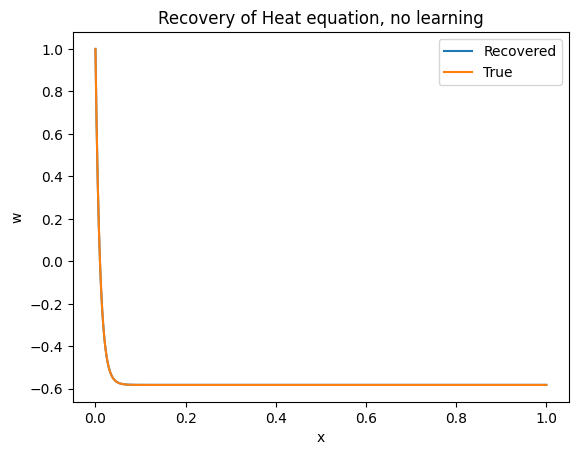

In [ ]:
#params = jnp.array([28])
K = matrix_assembly(train,params)
results_test = kernel_regression(X_test=antiburger_test,Y_train=Y[:len(K[:,0])],X_train=train,K_matrix= K,params=params,nugget=1*10**-13)
#Plot results
plt.plot(x,results_test)
plt.plot(x,heat(antiburger_test))
plt.xlabel('x')
plt.ylabel('w')
plt.legend(['Recovered','True'])
plt.title('Recovery of Heat equation, no learning')

In [ ]:
#test error
test_error = jnp.linalg.norm(results_test[:,0]-heat(test[:,0]))/jnp.linalg.norm(heat(test))
print(test_error)

0.0001873256799076496


Text(0.5, 1.0, 'Recovered Cole-Hopf, no learning')

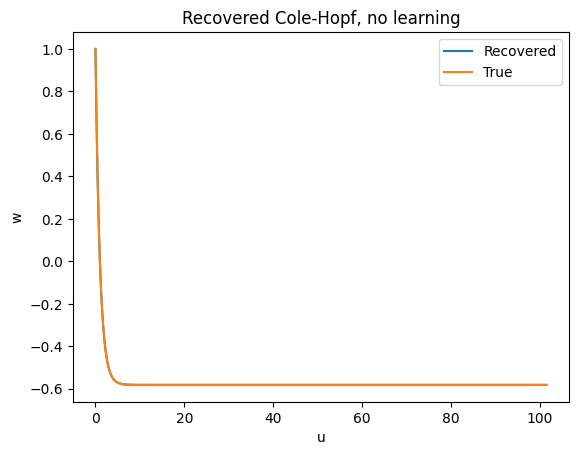

In [ ]:
plt.plot(antiburger_test,results_test[:,0])
plt.plot(antiburger_test,heat(antiburger_test))
plt.xlabel('u')
plt.ylabel('w')
plt.legend(['Recovered','True'])
plt.title('Recovered Cole-Hopf, no learning')

In [ ]:
#returns RKHS norm of kernel
def rkhs(params,lambda1=10**-13):

  K = matrix_assembly(antiburger_train[:,0].reshape((m+1,1)),params)

  rkhs = jnp.dot(Y[:,0],jnp.linalg.solve(K+lambda1*jnp.eye(len(K[:,0])),Y[:len(K[:,0])])[:,0])

  return rkhs

In [ ]:
rkhs(jnp.array([3.61]))

In [ ]:
#Code for gradient descent
def minimizer_momentum(init_params,n_iterations,learning_rate,momentum=0):

  params = init_params
  b = 0

  for i in tqdm.tqdm(range(n_iterations)):
    gradient = jax.grad(rho_alternative)(params)
    b = momentum*b+gradient
    params = params-learning_rate*b/np.sum(gradient*gradient,axis=None)
    print(params,rho_alternative(params))
  return params

In [ ]:
params_1 = minimizer_momentum(init_params=jnp.ones(1),n_iterations=100,learning_rate=10**-7)

In [ ]:
jnp.linalg.cholesky(K+10**-13*jnp.eye(len(K[:,0])))

Array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.10597662e-02,  1.18650719e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00